In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv("data.csv")
#print( df.corr() )
#print(df.head() )
df.describe()
df.head()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,IN022021900,"NEW DELHI SAFDARJUN, IN",2011-01-01,NaN,NaN,11.5,16.7,8.4
1,IN022021900,"NEW DELHI SAFDARJUN, IN",2011-01-02,NaN,NaN,10.8,14.6,7.8
2,IN022021900,"NEW DELHI SAFDARJUN, IN",2011-01-03,NaN,NaN,9.7,14.7,NaN
3,IN022021900,"NEW DELHI SAFDARJUN, IN",2011-01-04,NaN,NaN,8.3,14.7,3.7
4,IN022021900,"NEW DELHI SAFDARJUN, IN",2011-01-05,NaN,NaN,8.6,13.0,4.2


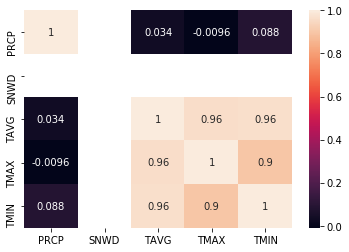

In [9]:
import seaborn as sns
#sns.pairplot(df,hue="TAVG")
sns.heatmap(df.corr(),annot=True)

Y has null values TAVG    False
dtype: bool
X has null value DATE    False
TMAX     True
TMIN     True
dtype: bool


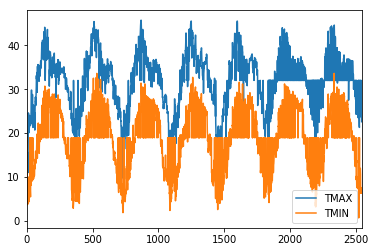

In [10]:


Y = pd.DataFrame(df["TAVG"] )
X1=df.drop(['SNWD','PRCP',"NAME","STATION","TAVG"], axis=1)

print("Y has null values" ,Y.isnull().any() ) 
print("X has null value",X1.isnull().any())

# fill nan values with mean

X1['TMAX'] = X1["TMAX"].fillna(X1["TMAX"].mean())
X1["TMIN"] =X1["TMIN"].fillna(X1["TMIN"].mean())

X1["DATE"]=pd.to_datetime(X1["DATE"])
X1.set_index("DATE")

X1.plot()



X=X1.drop("DATE",axis=1)

X=X.set_index(df["DATE"])
Y=Y.set_index(df["DATE"])


In [11]:
# shifting Data
shift_pr = 7

# # - upside shift
X_shift = X.shift(-shift_pr)
X_shift = X_shift[:-shift_pr]

Y_shift = Y.shift(shift_pr)
Y_shift = Y_shift[shift_pr:]

X=X_shift
Y=Y_shift

print(X.shape)
print(Y.shape)

(2539, 2)
(2539, 1)


In [12]:

print(X.columns)
from sklearn.preprocessing import MinMaxScaler
model_score = 0.8603871265
scale=MinMaxScaler()
X_trans=pd.DataFrame(scale.fit_transform(X) ,columns=['TMAX', 'TMIN'] )
print("Shape of X" , X.shape)

Y=Y.values.reshape(-1,1)
Y_trans= pd.DataFrame(scale.fit_transform(Y) , columns=["TAVG"])
print("Shape of Y", Y.shape)

Index(['TMAX', 'TMIN'], dtype='object')
Shape of X (2539, 2)
Shape of Y (2539, 1)


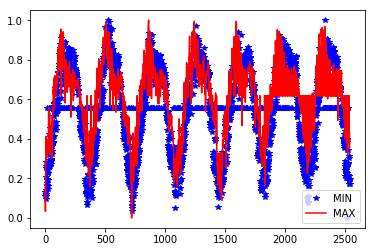

In [13]:
plt.plot(X_trans["TMIN"],"*b")
plt.plot(X_trans["TMAX"],"-r")
#plt.plot(Y_trans["TAVG"],"-g")
plt.legend(["MIN","MAX"])
plt.show()

In [14]:
# input require of (batchsize, timsteps, input_dim)

X_trans=X_trans.values.reshape(-1,1,2)


,TAVG
2525,0.301205
2526,0.322289
2527,0.274096
2528,0.210843
2529,0.183735
2530,0.201807
2531,0.243976
2532,0.280120
2533,0.259036
2534,0.295181


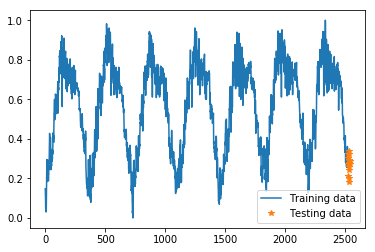

In [15]:
# trian Test split

cutpoint = "2017-12-11"
indexx = (X1[X1["DATE"] ==  cutpoint].index ).values[0]

X_train =X_trans[:indexx]
X_test = X_trans[indexx:]
y_train = Y_trans[:indexx]
y_test = Y_trans[indexx:]


plt.plot(y_train,"-")
plt.plot(y_test,"*")

plt.legend(["Training data","Testing data"])

y_test

In [16]:
X_train.shape

(2525, 1, 2)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam,RMSprop
import keras.backend as K

In [19]:
K.clear_session()

model=Sequential()

model.add(LSTM(2, input_shape=(1,2), return_sequences=True))
model.add(LSTM(3, ))
model.add(Dense(1))

model.compile(Adam(lr=0.001),"mean_squared_error")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 2)              40        
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_reduction= ReduceLROnPlateau(monitor='val_loss',factor=0.5, min_lr=0.00001,patience=1,verbose=1)

In [21]:
history= model.fit(X_train,y_train,batch_size=32,epochs=25,validation_split=0.1,callbacks=[lr_reduction])

Train on 2272 samples, validate on 253 samples
Epoch 1/25
2272/2272 [==============================] - 21s 9ms/step - loss: 0.3073 - val_loss: 0.3600
Epoch 2/25
2272/2272 [==============================] - 1s 477us/step - loss: 0.2038 - val_loss: 0.2358
Epoch 3/25
2272/2272 [==============================] - 1s 552us/step - loss: 0.1201 - val_loss: 0.1320
Epoch 4/25
2272/2272 [==============================] - 2s 665us/step - loss: 0.0660 - val_loss: 0.0680
Epoch 5/25
2272/2272 [==============================] - 2s 662us/step - loss: 0.0457 - val_loss: 0.0432
Epoch 6/25
2272/2272 [==============================] - 2s 721us/step - loss: 0.0417 - val_loss: 0.0370
Epoch 7/25
2272/2272 [==============================] - 1s 631us/step - loss: 0.0401 - val_loss: 0.0356
Epoch 8/25
2272/2272 [==============================] - 2s 822us/step - loss: 0.0382 - val_loss: 0.0335
Epoch 9/25
2272/2272 [==============================] - 2s 720us/step - loss: 0.0358 - val_loss: 0.0313
Epoch 10/25
2272/2

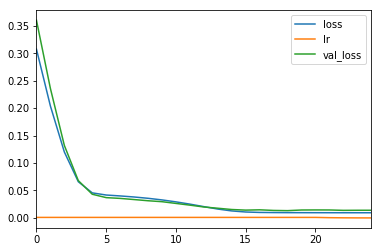

In [24]:
historydf= pd.DataFrame(history.history, index=history.epoch)
historydf.plot()

In [28]:
predicted_values=model.predict(X_test)

true_values = y_test

print((predicted_values - true_values))

          TAVG
2525  0.100305
2526 -0.012436
2527  0.011889
2528  0.226049
2529  0.140206
2530  0.117871
2531  0.018986
2532 -0.009904
2533  0.101442
2534  0.072677
2535 -0.051558
2536 -0.070237
2537 -0.011122
2538 -0.035426


In [30]:
from sklearn.metrics import mean_squared_error

# Error b/w True Values and Predicted Value
error=mean_squared_error(true_values, predicted_values)
print("Mean Square Error:", error)


print(f"Predicted Accuracy: {model_score}")



Mean Square Error: 0.008571960882715493
Predicted Accuracy 0.8603871265
